In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from tensorflow.python.framework import ops

In [10]:
epochs = 20
batch_size = 250
max_sequence_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005

In [3]:
data_dir = '../data'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os_makedirs(data_dir)
    
if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors='ignore')
    text_data = text_data.decode().split('\n')
    
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]
    
text_data = [x.split('\t') for x in text_data if len(x) >= 1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [4]:
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return text_string

text_data_train = [clean_text(x) for x in text_data_train]

In [5]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
    max_sequence_length, min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [6]:
text_processed = np.array(text_processed)
text_data_target = np.array([1 if x == 'ham' else 0 for x in text_data_target])
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

In [7]:
ix_cutoff = int(len(y_shuffled) * 0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]
vocab_size = len(vocab_processor.vocabulary_)
print('Vocabulary Size: {:d}'.format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


In [11]:
ops.reset_default_graph()
with tf.Session() as sess:
    dropout_keep_prob = tf.placeholder(tf.float32)
    x_data = tf.placeholder(tf.int32, [None, max_sequence_length])
    y_output = tf.placeholder(tf.int32, [None])
    
    embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))
    embeddding_output = tf.nn.embedding_lookup(embedding_mat, x_data)
    
    if tf.__version__[0] >= '1':
        cell = tf.contrib.rnn.BasicRNNCell(num_units = rnn_size)
    else:
        cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size)
        
    output, state = tf.nn.dynamic_rnn(cell, embeddding_output, dtype=tf.float32)
    output = tf.nn.dropout(output, dropout_keep_prob)
    output = tf.transpose(output, [1, 0, 2])
    last = tf.gather(output, int(output.get_shape()[0]) - 1)
    
    weight = tf.Variable(tf.truncated_normal([rnn_size, 2], stddev=0.1))
    bias = tf.Variable(tf.constant(0.1, shape=[2]))
    logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)
    losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
    loss = tf.reduce_mean(losses)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out, 1), tf.cast(y_output, tf.int64)), tf.float32))
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    train_step = optimizer.minimize(loss)
    init = tf.global_variables_initializer()
    sess.run(init)
    
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []
    for epoch in range(epochs):
        shuffled_ix = np.random.permutation(np.arange(len(x_train)))
        x_train = x_train[shuffled_ix]
        y_train = y_train[shuffled_ix]
        num_batches = int(len(x_train) / batch_size) + 1
        
        for i in range(num_batches):
            min_ix = i * batch_size
            max_ix = np.min([len(x_train), ((i + 1) * batch_size)])
            x_train_batch = x_train[min_ix:max_ix]
            y_train_batch = y_train[min_ix:max_ix]
            
            train_dict = {x_data: x_train_batch,
                          y_output: y_train_batch,
                          dropout_keep_prob: 0.5}
            sess.run(train_step, feed_dict=train_dict)
            
        temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
        train_loss.append(temp_train_loss)
        train_accuracy.append(temp_train_acc)
        
        test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob: 1.0}
        temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
        test_loss.append(temp_test_loss)
        test_accuracy.append(temp_test_acc)
        print('Epoch: {}, Test Loss: {:.2}, Test Acc: {:.2}'.format(epoch + 1, temp_test_loss, temp_test_acc))

/home/yskn67/.ghq/github.com/yskn67/tf_cookbook/tf_cookbook/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 1, Test Loss: 0.7, Test Acc: 0.18
Epoch: 2, Test Loss: 0.68, Test Acc: 0.84
Epoch: 3, Test Loss: 0.66, Test Acc: 0.85
Epoch: 4, Test Loss: 0.63, Test Acc: 0.85
Epoch: 5, Test Loss: 0.6, Test Acc: 0.85
Epoch: 6, Test Loss: 0.57, Test Acc: 0.86
Epoch: 7, Test Loss: 0.55, Test Acc: 0.86
Epoch: 8, Test Loss: 0.53, Test Acc: 0.86
Epoch: 9, Test Loss: 0.51, Test Acc: 0.87
Epoch: 10, Test Loss: 0.49, Test Acc: 0.87
Epoch: 11, Test Loss: 0.49, Test Acc: 0.87
Epoch: 12, Test Loss: 0.48, Test Acc: 0.87
Epoch: 13, Test Loss: 0.47, Test Acc: 0.87
Epoch: 14, Test Loss: 0.46, Test Acc: 0.87
Epoch: 15, Test Loss: 0.46, Test Acc: 0.87
Epoch: 16, Test Loss: 0.45, Test Acc: 0.87
Epoch: 17, Test Loss: 0.45, Test Acc: 0.87
Epoch: 18, Test Loss: 0.45, Test Acc: 0.88
Epoch: 19, Test Loss: 0.44, Test Acc: 0.88
Epoch: 20, Test Loss: 0.44, Test Acc: 0.88


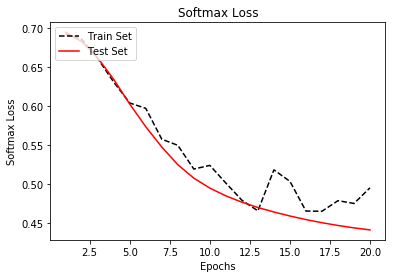

In [12]:
epoch_seq = np.arange(1, epochs + 1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

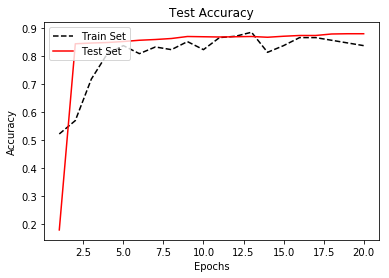

In [13]:
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()